In [1]:
import json
from collections import Counter, defaultdict

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [3]:
plt.rcParams["font.size"] = 14

In [4]:
def plot_freq(train_counts, savefig_path, xlabel='', ylabel=''):
    plt.figure()
    ax = train_counts.plot.bar(width=100.0, rot=0)
    ax.set_xticks(np.arange(0,len(train_counts),5000))
    ax.set_xticklabels(np.arange(0,len(train_counts),5000))
    ax.grid(which='major', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(-1000, len(train_counts)+1000)
    plt.savefig(savefig_path, bbox_inches='tight')

In [5]:
def count_unanswerable(target_dataset, train_counts):
    num_unanswerable = 0
    for _, item in target_dataset.iterrows():
        entity = item['entity']
        if entity not in train_counts:
            num_unanswerable += 1
    
    ratio_unanswerable = (1 - num_unanswerable / len(target_dataset)) 
    return num_unanswerable, ratio_unanswerable

In [6]:
def make_freq_accuracy_bins(prediction_path, train_counts, freq_bins):
    freq_bins = list(sorted(freq_bins))
    freq_accuracy_bins = defaultdict(list)
    
    with open(prediction_path) as f:
        for line in f:
            pred_data = json.loads(line)
            pred_answer = pred_data['top10_labels'][0]
            correct_answer = pred_data['metadata']['entity']
            sid = pred_data['metadata'].get('sentence_index')
            
            accuracy = int(pred_answer == correct_answer)

            if correct_answer in train_counts:
                freq = train_counts[correct_answer]
            else:
                freq = 0
            
            for bin_label in freq_bins[::-1]:
                if freq >= bin_label:
                    break
            else:
                continue
            
            freq_accuracy_bins[bin_label].append(accuracy)
                
    freq_mean_accuracies = defaultdict(float)
    for i, bin_label in enumerate(freq_bins):
        accuracies = freq_accuracy_bins[bin_label]
        assert len(accuracies) > 0
        mean_accuracy = sum(accuracies) / len(accuracies)
        if i < len(freq_bins) - 1 and freq_bins[i + 1] - bin_label == 1:
            freq_mean_accuracies[bin_label] = mean_accuracy
        else:
            freq_mean_accuracies[f'{bin_label}+'] = mean_accuracy
        
        last_label = bin_label
            
    return freq_mean_accuracies

In [7]:
def make_sid_accuracy_bins(prediction_path):
    sid_accuracy_bins = defaultdict(list)
    
    with open(prediction_path) as f:
        for line in f:
            pred_data = json.loads(line)
            pred_answer = pred_data['top10_labels'][0]
            correct_answer = pred_data['metadata']['entity']
            sid = pred_data['metadata'].get('sentence_index')
            
            accuracy = int(pred_answer == correct_answer)
            
            if sid is not None:
                sid += 1  # 0-origin -> 1-origin
                sid_label = '7+' if sid >= 7 else str(sid)
                sid_accuracy_bins[sid_label].append(accuracy)
        
    sid_mean_accuracies = defaultdict(float)
    for label in ['1', '2', '3', '4', '5', '6', '7+']:
        if label in sid_accuracy_bins:
            accuracies = sid_accuracy_bins[label]
            assert len(accuracies) > 0
            mean_accuracy = sum(accuracies) / len(accuracies)
            sid_mean_accuracies[label] = mean_accuracy
            
    return sid_mean_accuracies

In [8]:
def plot_accuracies(accuracies, savefig_path, xlabel='', ylabel=''):
    plt.figure()
    ax = accuracies.plot.bar(rot=0)
    ax.grid(which='major', axis='y', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(fontsize=12)
    plt.savefig(savefig_path, bbox_inches='tight')

## Quizbowl

In [9]:
QB_TRAIN_PATH = "work/dataset/quizbowl/train_question.json"
QB_DEV_PATH = "work/dataset/quizbowl/dev_question.json"
QB_EVAL_PATH = "work/dataset/quizbowl/eval_question.json"
QB_TEST_PATH = "work/dataset/quizbowl/test_question.json"

In [10]:
qb_train = pd.read_json(open(QB_TRAIN_PATH).read(), orient='records', lines=True)
qb_dev = pd.read_json(open(QB_DEV_PATH).read(), orient='records', lines=True)
qb_eval = pd.read_json(open(QB_EVAL_PATH).read(), orient='records', lines=True)
qb_test = pd.read_json(open(QB_TEST_PATH).read(), orient='records', lines=True)

In [11]:
qb_train.head()

,qanta_id,text,entity,text_unit
0,0,After this character relates a story about how...,Queequeg,question
1,1,The oldest document written in this language i...,Romanian_language,question
2,2,This state's largest city endured an 1855 Rum ...,Maine,question
3,3,"In one work, this man provides definitions for...",Charles_Sanders_Peirce,question
4,4,One family in this work flees France after res...,Frankenstein,question


In [12]:
qb_train_counts = qb_train['entity'].value_counts()
print(qb_train_counts)

Japan                    99
China                    97
Australia                97
Spain                    89
Brazil                   87
                         ..
Abel_Gance                1
Arithmetic_logic_unit     1
Acid–base_titration       1
Mycenaean_Greece          1
Kolmogorov_complexity     1
Name: entity, Length: 25969, dtype: int64


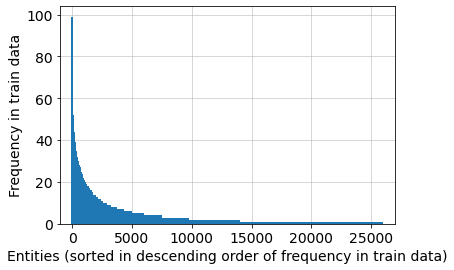

In [13]:
plot_freq(qb_train_counts,
          savefig_path='images/quizbowl_train_freq.pdf',
          xlabel='Entities (sorted in descending order of frequency in train data)',
          ylabel='Frequency in train data')

In [14]:
count_unanswerable(qb_dev, qb_train_counts)

(0, 1.0)

In [15]:
count_unanswerable(qb_eval, qb_train_counts)

(307, 0.8614620938628159)

In [16]:
count_unanswerable(qb_test, qb_train_counts)

(648, 0.8421052631578947)

In [17]:
QB_EVAL_PRED_QUIZ_PATH = 'work/quizbowl/quiz/bert-base/prediction_eval_question.json'
QB_EVAL_PRED_WIKI_TO_QUIZ_PATH = 'work/quizbowl/wiki_to_quiz/bert-base/prediction_eval_question.json'

In [18]:
freq_bins = [1, 2, 5, 10]
qb_freq_accuracies_quiz = make_freq_accuracy_bins(QB_EVAL_PRED_QUIZ_PATH, qb_train_counts, freq_bins)
qb_freq_accuracies_wiki_to_quiz = make_freq_accuracy_bins(QB_EVAL_PRED_WIKI_TO_QUIZ_PATH, qb_train_counts, freq_bins)

In [20]:
freq_labels = qb_freq_accuracies_quiz.keys()
qb_freq_accuracies = pd.DataFrame(
    data={
        'Quiz': [qb_freq_accuracies_quiz[label] for label in freq_labels],
        r'Wiki$\rightarrow$Quiz': [qb_freq_accuracies_wiki_to_quiz[label] for label in freq_labels]
    },
    index=freq_labels)

In [21]:
qb_freq_accuracies

,Quiz,Wiki$\rightarrow$Quiz
1,0.365000,0.510000
2+,0.704000,0.789333
5+,0.844193,0.889518
10+,0.902141,0.910296


<Figure size 432x288 with 0 Axes>

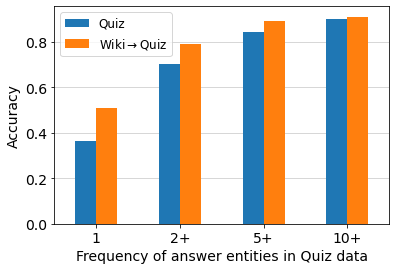

In [22]:
plot_accuracies(qb_freq_accuracies,
                savefig_path='images/quizbowl_freq_accuracies.pdf',
                xlabel='Frequency of answer entities in Quiz data',
                ylabel='Accuracy')

In [ ]:
QB_DEV_PRED_QUIZ_SENT_PATH = 'work/quizbowl/quiz/bert-base/prediction_dev_sentence.json'
QB_DEV_PRED_WIKI_TO_QUIZ_SENT_PATH = 'work/quizbowl/wiki_to_quiz/bert-base/prediction_dev_sentence.json'

In [ ]:
qb_sid_accuracies_quiz = make_sid_accuracy_bins(QB_DEV_PRED_QUIZ_SENT_PATH)
qb_sid_accuracies_wiki_to_quiz = make_sid_accuracy_bins(QB_DEV_PRED_WIKI_TO_QUIZ_SENT_PATH)

In [ ]:
sid_labels = qb_sid_accuracies_quiz.keys()
sid_accuracies = pd.DataFrame(
    data={
        'Quiz': [qb_sid_accuracies_quiz[label] for label in sid_labels],
        r'Wiki$\rightarrow$Quiz': [qb_sid_accuracies_wiki_to_quiz[label] for label in sid_labels]
    },
    index=sid_labels)

In [ ]:
sid_accuracies

In [ ]:
plot_accuracies(sid_accuracies,
                savefig_path='images/quizbowl_sid_accuracies.pdf',
                xlabel='Question sentence index',
                ylabel='Accuracy')

## TriviaQA

In [19]:
TQ_TRAIN_PATH = "work/dataset/triviaqa/train_question.json"
TQ_DEV_PATH = "work/dataset/triviaqa/dev_question.json"
TQ_EVAL_PATH = "work/dataset/triviaqa/dev_question.json"
TQ_WIKI_PATH = "work/dataset/triviaqa/wiki_sentence_blingfire.json"

In [23]:
tq_train = pd.read_json(open(TQ_TRAIN_PATH).read(), orient='records', lines=True)
tq_dev = pd.read_json(open(TQ_DEV_PATH).read(), orient='records', lines=True)
tq_eval = pd.read_json(open(TQ_EVAL_PATH).read(), orient='records', lines=True)
tq_wiki = pd.read_json(open(TQ_WIKI_PATH).read(), orient='records', lines=True)

In [24]:
tq_train.head()

,question_id,text,entity
0,tc_0,Who was President when the first Peanuts carto...,Harry_S._Truman
1,tc_1,Which American-born Sinclair won the Nobel Pri...,Sinclair_Lewis
2,tc_3,Where in England was Dame Judi Dench born?,York
3,tc_5,In which decade did Billboard magazine first p...,30s
4,tc_8,From which country did Angola achieve independ...,Portugal


In [25]:
tq_train_counts = tq_train['entity'].value_counts()

In [26]:
tq_train_counts

Australia         153
France            133
New_Zealand       114
Spain             102
Italy             100
                 ... 
Ur                  1
Scoville_scale      1
Keswick             1
Komodo_dragon       1
Muscat              1
Name: entity, Length: 28689, dtype: int64

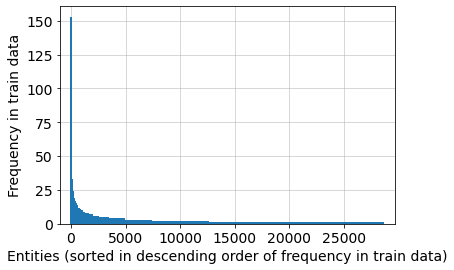

In [27]:
plot_freq(tq_train_counts,
          savefig_path='images/triviaqa_train_freq.pdf',
          xlabel='Entities (sorted in descending order of frequency in train data)',
          ylabel='Frequency in train data')

In [28]:
TQ_EVAL_PRED_QUIZ_PATH = 'work/triviaqa/quiz/bert-base_30ep/prediction_eval_question.json'
TQ_EVAL_PRED_WIKI_TO_QUIZ_PATH = 'work/triviaqa/wiki_to_quiz/bert-base/prediction_eval_question.json'

In [29]:
freq_bins = [1, 2, 5, 10]
tq_freq_accuracies_quiz = make_freq_accuracy_bins(TQ_EVAL_PRED_QUIZ_PATH, tq_train_counts, freq_bins)
tq_freq_accuracies_wiki_to_quiz = make_freq_accuracy_bins(TQ_EVAL_PRED_WIKI_TO_QUIZ_PATH, tq_train_counts, freq_bins)

In [30]:
freq_labels = tq_freq_accuracies_quiz.keys()
tq_freq_accuracies = pd.DataFrame(
    data={
        'Quiz (30 epochs)': [tq_freq_accuracies_quiz[label] for label in freq_labels],
        r'Wiki$\rightarrow$Quiz': [tq_freq_accuracies_wiki_to_quiz[label] for label in freq_labels]
    },
    index=freq_labels)

In [31]:
tq_freq_accuracies

,Quiz (30 epochs),Wiki$\rightarrow$Quiz
1,0.275407,0.440041
2+,0.437993,0.560879
5+,0.492013,0.587061
10+,0.447461,0.543992


<Figure size 432x288 with 0 Axes>

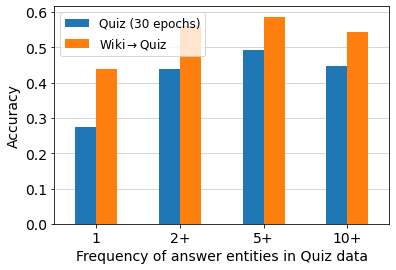

In [32]:
plot_accuracies(tq_freq_accuracies,
                savefig_path='images/triviaqa_freq_accuracies.pdf',
                xlabel='Frequency of answer entities in Quiz data',
                ylabel='Accuracy')

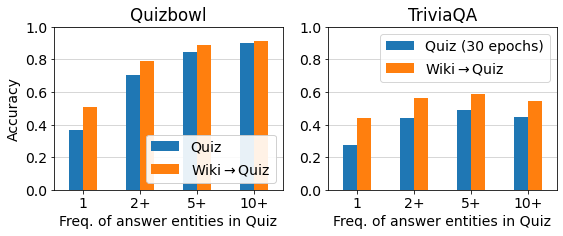

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))
qb_freq_accuracies.plot.bar(ax=axes[0], ylim=(0.0, 1.0), rot=0, title='Quizbowl')
axes[0].grid(which='major', axis='y', linewidth=0.5)
axes[0].set_axisbelow(True)
axes[0].set_xlabel('Freq. of answer entities in Quiz')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right', framealpha=0.9)
tq_freq_accuracies.plot.bar(ax=axes[1], ylim=(0.0, 1.0), rot=0, title='TriviaQA')
axes[1].grid(which='major', axis='y', linewidth=0.5)
axes[1].set_axisbelow(True)
axes[1].set_xlabel('Freq. of answer entities in Quiz')
plt.savefig('images/freq_accuracies.pdf', bbox_inches='tight')

### Qualitative Analysis

In [41]:
TQ_DEV_PRED_QUIZ_PATH = 'work/triviaqa/quiz/bert-base_30ep/prediction_dev_question.json'
TQ_DEV_PRED_WIKI_TO_QUIZ_PATH = 'work/triviaqa/wiki_to_quiz/bert-base/prediction_dev_question.json'

In [42]:
tq_dev = pd.read_json(open(TQ_DEV_PATH).read(), orient='records', lines=True)

In [43]:
tq_dev_pred_quiz = pd.read_json(open(TQ_DEV_PRED_QUIZ_PATH).read(), orient='records', lines=True)
tq_dev_pred_wiki_to_quiz = pd.read_json(open(TQ_DEV_PRED_WIKI_TO_QUIZ_PATH).read(), orient='records', lines=True)

In [44]:
tq_dev_pred = tq_dev.join(tq_dev_pred_quiz).join(tq_dev_pred_wiki_to_quiz, lsuffix='_quiz', rsuffix='_wiki_to_quiz')

In [45]:
tq_dev_pred

,question_id,text,entity,metadata_quiz,top10_labels_quiz,rank_quiz,metadata_wiki_to_quiz,top10_labels_wiki_to_quiz,rank_wiki_to_quiz
0,tc_33,Which Lloyd Webber musical premiered in the US...,Sunset_Boulevard,"{'question_id': 'tc_33', 'text': 'Which Lloyd ...","[Cat, Cats_(disambiguation), Jesus_Christ_Supe...",72,"{'question_id': 'tc_33', 'text': 'Which Lloyd ...","[The_Lion_King, Starlight_Express, Cats_(disam...",63
1,tc_40,Who was the next British Prime Minister after ...,Henry_Campbell-Bannerman,"{'question_id': 'tc_40', 'text': 'Who was the ...","[James_Callaghan, Alec_Douglas-Home, Tony_Blai...",233,"{'question_id': 'tc_40', 'text': 'Who was the ...","[David_Lloyd_George, Stanley_Baldwin, Bonar_La...",60
2,tc_56,What claimed the life of singer Kathleen Ferrier?,Cancer,"{'question_id': 'tc_56', 'text': 'What claimed...","[Loch_Ness_Monster, Santa_Claus, Ned_Kelly, Th...",9097,"{'question_id': 'tc_56', 'text': 'What claimed...","[Peter_Sutcliffe, Jack_the_Ripper, Charles_Man...",14507
3,tc_106,Which actress was voted Miss Greenwich Village...,Lauren_Bacall,"{'question_id': 'tc_106', 'text': 'Which actre...","[Debbie_Reynolds, Elizabeth_Taylor, Marilyn_Mo...",16,"{'question_id': 'tc_106', 'text': 'Which actre...","[Elizabeth_Taylor, Lana_Turner, Lauren_Bacall,...",3
4,tc_217,Which volcano in Tanzania is the highest mount...,Mount_Kilimanjaro,"{'question_id': 'tc_217', 'text': 'Which volca...","[Mount_Kilimanjaro, Mount_Kenya, Aconcagua, Do...",1,"{'question_id': 'tc_217', 'text': 'Which volca...","[Mount_Kilimanjaro, Mount_Kenya, Kenya, Lake_T...",1
...,...,...,...,...,...,...,...,...,...
5994,qg_4549,"Where do you find the Bridal Veil, American, a...",Niagara_Falls,"{'question_id': 'qg_4549', 'text': 'Where do y...","[Niagara_Falls, Washington, San_Francisco, Phi...",1,"{'question_id': 'qg_4549', 'text': 'Where do y...","[Niagara_Falls, Disneyland, Jungle_Cruise, New...",1
5995,qg_4592,Whose backing band is known as The Miami Sound...,Gloria_Estefan,"{'question_id': 'qg_4592', 'text': 'Whose back...","[David_Bowie, U2, Phil_Collins, Green_Day, Bru...",3469,"{'question_id': 'qg_4592', 'text': 'Whose back...","[Jools_Holland, Sting, Justin_Timberlake, Glor...",4
5996,qg_4604,"With a motto of Always Ready, Always There, wh...",National_Guard,"{'question_id': 'qg_4604', 'text': 'With a mot...","[United_States_Coast_Guard, Federal_Bureau_of_...",14,"{'question_id': 'qg_4604', 'text': 'With a mot...","[United_States_Coast_Guard, United_States_Mari...",6
5997,qg_4628,What is the name of the parson mentioned in th...,Brown,"{'question_id': 'qg_4628', 'text': 'What is th...","[Jack, Santa_Claus, Hatmaking, Polly, Lewis_Ca...",7528,"{'question_id': 'qg_4628', 'text': 'What is th...","[Dasher, Jack, God_Rest_You_Merry,_Gentlemen, ...",9771


In [50]:
tq_dev_pred_improved = tq_dev_pred.query('rank_quiz > 1 and rank_wiki_to_quiz == 1')

In [58]:
for t in tq_dev_pred_improved.itertuples():
    if t.entity == 'Charlie_Chan':
        print('[* Question ID:]', t.question_id)
        print('[* Q.]', t.text)
        print('[* A.]', t.entity)
        print('[* Training Questions:]')
        for question in tq_train.query(f'entity == "{t.entity}"')['text'].tolist():
            print('', question)
        print('[* Rank (Quiz, Wiki->Quiz):]', t.rank_quiz, '->', t.rank_wiki_to_quiz)
        print('[* Top 10 (Quiz):]', ', '.join(t.top10_labels_quiz))
        print('[* Top 10 (Wiki->Quiz):]', ', '.join(t.top10_labels_wiki_to_quiz))
        print()

[* Question ID:] qw_5335
[* Q.] What fictional Chinese-American detective, created by Earl Derr Biggers in 1923 for a novel published in 1925, was the subject of over 45 films made between 1926 and 1981?
[* A.] Charlie_Chan
[* Training Questions:]
 Which retro film character frequently referred to his ‘Number One son’ in his films?
 Warner Oland, Sydney Toler and Roland Winters have all played which fictional detective?
[* Rank (Quiz, Wiki->Quiz):] 3 -> 1
[* Top 10 (Quiz):] Earl_Derr_Biggers, Philip_Marlowe, Charlie_Chan, Fu_Manchu, Sax_Rohmer, Lord_Peter_Wimsey, John_Shaft, Shaft, Perry_Mason, Aladdin
[* Top 10 (Wiki->Quiz):] Charlie_Chan, Earl_Derr_Biggers, Wyatt_Earp, Fu_Manchu, The_Flower_Drum_Song, Popeye, Dashiell_Hammett, Scarlett_O'Hara, Bruce_Lee, The_Great_Gatsby

[* Question ID:] sfq_18010
[* Q.] Which literary character is the best known creation of the writer Earl Derr Biggers?
[* A.] Charlie_Chan
[* Training Questions:]
 Which retro film character frequently referred to h

In [48]:
tq_wiki.query('entity == "Charlie_Chan" and text.str.contains("fictional")')['text'].tolist()

['Charlie Chan is a fictional character created by Earl Derr Biggers.']